# Import Libraries


In [8]:
import pandas as pd
import numpy as np
import os

from sklearn.utils import shuffle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import plotly.express as px
import psutil

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, precision_recall_fscore_support

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential 
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, InputLayer
from scikeras.wrappers import KerasClassifier
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder



# Data loading functions

In [16]:
# Define function to load training data from individual files
def load_training_data(folder_path, count, authors_to_include=[]):
    numbers_list = [num for num in range(1, count+1)]
    data_list = []
    filename_list = []
    iterator = 0
    for filename in os.listdir(folder_path):
        # Check if the filename contains "aggr"
            if "aggr" in filename and "complete" not in filename:
                num = filename.split("_")[2]
                if int(num) in numbers_list:
                    if iterator < count:
                        iterator += 1
                        file_path = os.path.join(folder_path, filename)
                        df = pd.read_csv(file_path, encoding='latin-1')
                        if authors_to_include:
                            df = df[df["Author"].isin(authors_to_include)]
                        # Replace NaN values with 0.0
                        df.fillna(0.0, inplace=True)
                        if df.isnull().values.any():
                            print(f"NaN values found in DataFrame: {filename}")
                            print(df[df.isnull().any(axis=1)])
                        data_list.append(df)
                        filename_list.append(filename)
    return pd.concat(data_list, ignore_index=True)

# Define function to load testing data from a single file
def load_testing_data(folder_path, count, count_adder, authors_to_include=[]):
    numbers_list = [num for num in range(count_adder+1, count_adder+count+1)]
    data_list = []
    filename_list = []
    iterator = 0
    count_iterator = 1
    for filename in os.listdir(folder_path):
        # Check if the filename contains "aggr"
            num = filename.split("_")[2]
            if "aggr" in filename and "complete" not in filename and int(num) in numbers_list:
                count_iterator += 1
                if iterator < count:
                    iterator += 1
                    file_path = os.path.join(folder_path, filename)
                    df = pd.read_csv(file_path, encoding='latin-1')
                    # Replace NaN values with 0.0
                    if authors_to_include:
                        df = df[df["Author"].isin(authors_to_include)]
                    df.fillna(0.0, inplace=True)
                    data_list.append(df)
                    filename_list.append(filename)
    return pd.concat(data_list, ignore_index=True)

def create_complete_data(folder_path, authors_to_include=[]):
    authors_set = set(authors_to_include)
    print(f"Memory before reading all files in: {psutil.virtual_memory().percent}%")
    combined_df = None
    for filename in os.listdir(folder_path):
        if "aggr" in filename and "complete" not in filename:
            file_path = os.path.join(folder_path, filename)

            df = pd.read_csv(file_path, encoding='latin-1')

            if authors_to_include:
                df = df[df["Author"].isin(authors_set)]

            if df.isnull().values.any():
                print(f"NaN values found in DataFrame: {filename}")
            df.fillna(0.0, inplace=True)

            if combined_df is None:
                combined_df = df
            else:
                combined_df = pd.concat([combined_df, df])
    return combined_df


# def optimize_dataframe(df):
#     for col in df.select_dtypes(include=["float", "int"]).columns:
#         df[col] = pd.to_numeric(df[col], downcast="float" if df[col].dtype == "float64" else "integer")
#     for col in df.select_dtypes(include=["object"]).columns:
#         if df[col].nunique() < 0.5 * len(df):
#             df[col] = df[col].astype("category")
#     return df

# def create_complete_data(folder_path, authors_to_include=[], chunksize=100):
#     authors_set = set(authors_to_include)
#     dfs = []

#     for filename in os.listdir(folder_path):
#         if "aggr" in filename and "complete" not in filename:
#             file_path = os.path.join(folder_path, filename)
#             chunk_list = []
#             for chunk in pd.read_csv(file_path, encoding='latin-1', chunksize=chunksize):
#                 if authors_to_include:
#                     chunk = chunk[chunk["Author"].isin(authors_set)]

#                 chunk.fillna(0.0, inplace=True)
#                 chunk_list.append(optimize_dataframe(chunk))

#             file_df = pd.concat(chunk_list, ignore_index=True)
#             dfs.append(file_df)

#     combined_df = pd.concat(dfs, ignore_index=True)
#     return combined_df

# Random Forest Model

In [ ]:
bom_folder_path = "BOM_authors_csv"
bible_folder_path = "Bible_authors_csv"
dc_folder_path = "DC_authors_csv"
pogp_folder_csv = "POGP_authors_csv"
hebrews_folder_path = "hebrews_authors_csv"
latewar_folder_path = "latewar_authors_csv"
spaulding_folder_csv = "SPAULDING_authors_csv"

desired_authors = ["nephi", "jacob", "moroni", "mormon", "enos"]
bom_df = create_complete_data(bom_folder_path, authors_to_include=desired_authors)
bible_df = create_complete_data(bible_folder_path)
dc_df = create_complete_data(dc_folder_path)
pogp_df = create_complete_data(pogp_folder_csv)
hebrews_df = create_complete_data(hebrews_folder_path)
latewar_df = create_complete_data(latewar_folder_path)
spaudling_df = create_complete_data(spaulding_folder_csv)



df = pd.concat([bom_df, dc_df, pogp_df, hebrews_df, latewar_df, spaudling_df], ignore_index=True)
df = df.fillna(0)
target = df["Author"]
features = df.drop(columns=["Author"])
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# hyperparameters = {'bootstrap': True, 
#                     'max_depth': None, 
#                     'min_samples_leaf': 2, 
#                     'min_samples_split': 10, 
#                     'n_estimators': 500}

#hyperparameters = {'bootstrap': False, 'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}

hyperparameters = {'bootstrap': False,
             'max_depth': 39,
             'min_samples_leaf': 2,
             'min_samples_split': 2,
             'n_estimators': 631}


rf_model = RandomForestClassifier(**hyperparameters)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted')  
f1 = f1_score(y_test, y_pred, average='weighted')  

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)





Accuracy: 0.82
Precision: 0.8206242209802581
Recall: 0.82
F1-Score: 0.818946687874801


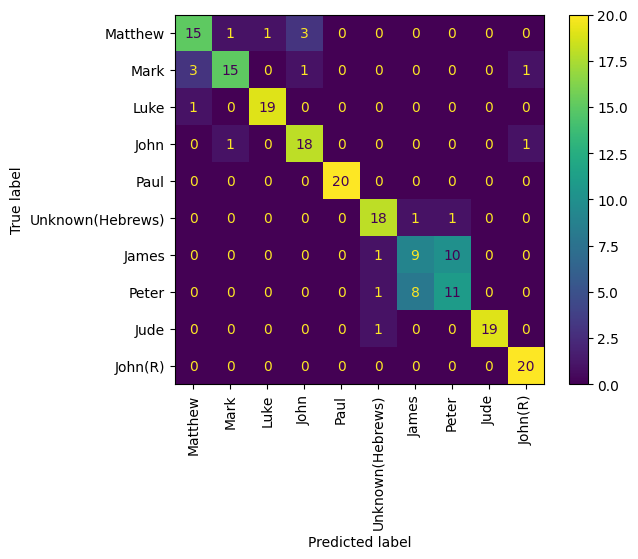

In [28]:
cm = confusion_matrix(y_test, y_pred, labels=target.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target.unique())
disp.plot(cmap="viridis", xticks_rotation='vertical')

## RF Cross Validation

In [6]:
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=50)

print("Cross-validation scores:", cv_scores)

print("Mean CV score:", np.mean(cv_scores))
print("Standard deviation of CV scores:", np.std(cv_scores))

feature_importances = rf_model.feature_importances_
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

importances_df_top5 = importances_df.head(5)
print(importances_df_top5)

Cross-validation scores: [0.73913043 0.69565217 0.69565217 0.65217391 0.69565217 0.56521739
 0.73913043 0.73913043 0.73913043 0.73913043 0.65217391 0.65217391
 0.69565217 0.65217391 0.73913043 0.65217391 0.73913043 0.73913043
 0.56521739 0.73913043 0.77272727 0.81818182 0.81818182 0.81818182
 0.77272727 0.77272727 0.77272727 0.77272727 0.77272727 0.77272727
 0.68181818 0.81818182 0.72727273 0.81818182 0.77272727 0.77272727
 0.86363636 0.77272727 0.72727273 0.77272727 0.77272727 0.77272727
 0.72727273 0.72727273 0.72727273 0.68181818 0.77272727 0.72727273
 0.72727273 0.72727273]
Mean CV score: 0.7356126482213438
Standard deviation of CV scores: 0.05924278867348432
                       Feature  Importance
332           Total_Word_Count    0.067251
333  Total_Function_Word_Count    0.059606
335         AVG_Word_Per_Verse    0.050553
330          Ã¢_percentage_use    0.032666
313           j_percentage_use    0.024848


## RF Grid Search

In [ ]:
param_grid = {
    'n_estimators': [250, 500],
    'max_depth': [5, 15,100, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [2, 5, 7, 10, 15],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)
print("Best Model:", best_model)

Best Hyperparameters: {'bootstrap': False, 'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
Best Model: RandomForestClassifier(bootstrap=False, max_depth=100, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=500, random_state=42)


## RF Bayesian Hyperparameter Search 

In [ ]:
param_space = {
    "n_estimators": Integer(100, 1000),          
    "max_depth": Integer(5, 50),                 
    "min_samples_split": Integer(2, 20),        
    "min_samples_leaf": Integer(1, 10),         
    "bootstrap": Categorical([True, False]),   
}


bayes_search = BayesSearchCV(
    estimator=rf_model,
    search_spaces=param_space,
    n_iter=50,  
    cv=5,       
    scoring='accuracy', 
    random_state=42,
    verbose=2
)


bayes_search.fit(X_train, y_train)


print("Best Parameters:", bayes_search.best_params_)

y_pred = bayes_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted')  
f1 = f1_score(y_test, y_pred, average='weighted')  

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=9, min_samples_split=8, n_estimators=703; total time=   2.5s
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=9, min_samples_split=8, n_estimators=703; total time=   2.5s
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=9, min_samples_split=8, n_estimators=703; total time=   2.5s
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=9, min_samples_split=8, n_estimators=703; total time=   2.4s
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=9, min_samples_split=8, n_estimators=703; total time=   2.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, max_depth=45, min_samples_leaf=4, min_samples_split=19, n_estimators=878; total time=   4.5s
[CV] END bootstrap=False, max_depth=45, min_samples_leaf=4, min_samples_split=19, n_estimators=878; total time=   4.7s
[CV] END bootstrap=False, max_depth=45, min_samples_leaf=4,

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bayes_search.best_params_

OrderedDict([('bootstrap', False),
             ('max_depth', 39),
             ('min_samples_leaf', 2),
             ('min_samples_split', 2),
             ('n_estimators', 631)])

# K Neighbors Model

In [9]:
bom_folder_path = "BOM_authors_csv"
bible_folder_path = "Bible_authors_csv"
dc_folder_path = "DC_authors_csv"
pogp_folder_csv = "POGP_authors_csv"
hebrews_folder_path = "hebrews_authors_csv"
latewar_folder_path = "latewar_authors_csv"
spaulding_folder_csv = "SPAULDING_authors_csv"

desired_authors = ["nephi", "jacob", "moroni", "mormon", "enos"]
bom_df = create_complete_data(bom_folder_path, authors_to_include=desired_authors)
bible_df = create_complete_data(bible_folder_path)
dc_df = create_complete_data(dc_folder_path)
pogp_df = create_complete_data(pogp_folder_csv)
hebrews_df = create_complete_data(hebrews_folder_path)
latewar_df = create_complete_data(latewar_folder_path)
spaudling_df = create_complete_data(spaulding_folder_csv)



df = pd.concat([bom_df, dc_df, pogp_df, hebrews_df, latewar_df, spaudling_df], ignore_index=True)
df = df.fillna(0)
target = df["Author"]
features = df.drop(columns=["Author"])
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, y_train)


predictions = knn.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')  # Other options: 'micro', 'macro'
recall = recall_score(y_test, predictions, average='weighted')  # Other options: 'micro', 'macro'
f1 = f1_score(y_test, predictions, average='weighted')  # Other options: 'micro', 'macro'

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.7285714285714285
Precision: 0.6672747755228574
Recall: 0.7285714285714285
F1-Score: 0.6802171216488548


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## K Neighbors Confusion Grid

In [113]:
cm = confusion_matrix(y_test, predictions, labels=target.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target.unique())
disp.plot(cmap="viridis", xticks_rotation='vertical')

ValueError: Found input variables with inconsistent numbers of samples: [160, 280]

# Neural Net Model

## Model Creation

In [76]:
def create_model(X_train, num_authors, structure):
  features_in_data = X_train.shape[1]
  model = Sequential()
  model.add(Dense(features_in_data, input_dim=features_in_data, activation='relu'))
  for i in structure:
    model.add(Dense(i, activation='relu'))
    model.add(Dropout(0.3))
    #model.add(BatchNormalization())
  model.add(Dense(num_authors, activation = 'softmax' ))
  #custom_learning_rate = 0.001
  custom_learning_rate = 0.01
  optimizer = Adam(learning_rate=custom_learning_rate)
  model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics = ['accuracy'])
  return model

## Load Data & Run Model

In [12]:
bom_folder_path = "BOM_authors_csv"
bible_folder_path = "Bible_authors_csv"
dc_folder_path = "DC_authors_csv"
pogp_folder_csv = "POGP_authors_csv"
hebrews_folder_path = "hebrews_authors_csv"
latewar_folder_path = "latewar_authors_csv"
spaulding_folder_csv = "SPAULDING_authors_csv"

desired_authors = ["nephi", "jacob", "moroni", "mormon", "enos"]
bom_df = create_complete_data(bom_folder_path, authors_to_include=desired_authors)
bible_df = create_complete_data(bible_folder_path)
dc_df = create_complete_data(dc_folder_path)
pogp_df = create_complete_data(pogp_folder_csv)
hebrews_df = create_complete_data(hebrews_folder_path)
latewar_df = create_complete_data(latewar_folder_path)
spaudling_df = create_complete_data(spaulding_folder_csv)



df = pd.concat([bom_df, dc_df, pogp_df, hebrews_df, latewar_df, spaudling_df], ignore_index=True)
df = df.fillna(0)
target = df["Author"]
features = df.drop(columns=["Author"])
minMaxScaler = MinMaxScaler()
features_scaled = pd.DataFrame(minMaxScaler.fit_transform(features), columns=features.columns)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [19]:
df = pd.concat([bom_df, dc_df, pogp_df, hebrews_df, latewar_df, spaudling_df], ignore_index=True)
df = df.fillna(0)
target = df["Author"]
features = df.drop(columns=["Author"])
minMaxScaler = MinMaxScaler()
features_scaled = pd.DataFrame(minMaxScaler.fit_transform(features), columns=features.columns)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [22]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
num_authors = len(label_encoder.classes_)

optimizer = Adam(learning_rate=0.001)

structure =[
256,128
]

model = create_model(X_train, num_authors, structure)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])


early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(X_train, y_train_encoded, epochs=1000, validation_split=0.08, batch_size=250, callbacks=[early_stop], shuffle=True)
hist = pd.DataFrame(history.history)

scikit_nn = KerasClassifier(build_fn=create_model(X_train, num_authors, structure), epochs=1000, batch_size=128, callbacks=[early_stop], shuffle=True)

c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1004 - loss: 2.3966 - val_accuracy: 0.4405 - val_loss: 2.0510
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5220 - loss: 1.6788 - val_accuracy: 0.5952 - val_loss: 1.6494
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6644 - loss: 1.2002 - val_accuracy: 0.6667 - val_loss: 1.3784
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7210 - loss: 0.8787 - val_accuracy: 0.7024 - val_loss: 1.2024
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7938 - loss: 0.7235 - val_accuracy: 0.7143 - val_loss: 1.0109
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8146 - loss: 0.6001 - val_accuracy: 0.7143 - val_loss: 0.9302
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8284 - loss: 0.5145 - val_accuracy: 0.7381 - val_loss: 0.8060
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8276 - loss: 0.4543 - val_accuracy: 0.7262 - val_loss: 0.7390


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
class_names = label_encoder.classes_
label_to_name = dict(zip(range(len(class_names)), class_names))
y_pred = model.predict(X_test)
all_labels = pd.concat([y_train, y_test], axis=0)
label_encoder.fit(all_labels)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
predicted_labels = label_encoder.inverse_transform(y_pred.argmax(axis=1))

accuracy = accuracy_score(y_test, predicted_labels)

precision, recall, f1_score_nn, support = precision_recall_fscore_support(y_test, predicted_labels, average='weighted')

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score_nn)
print("Support:", support)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy: 0.6678571428571428
Precision: 0.6946005030167314
Recall: 0.6678571428571428
F1 Score: 0.6346160045945223
Support: None


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


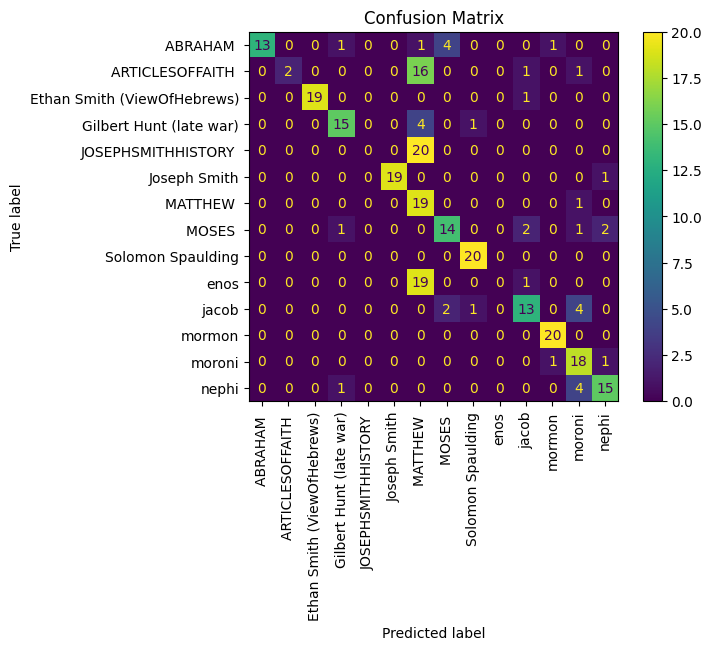

In [56]:

all_labels = pd.concat([y_train, y_test], axis=0)
label_encoder.fit(all_labels)


y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


predicted_labels = label_encoder.inverse_transform(y_pred.argmax(axis=1))



cm = confusion_matrix(y_test, predicted_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="viridis", xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

# Xg Boost Regressor Model 

In [ ]:
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_author = encoder.fit_transform(df[['Author']])
encoded_author_df = pd.DataFrame(encoded_author, columns=encoder.get_feature_names_out(['Author']))

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
minMaxScaler = MinMaxScaler()

column_scores = {}
for i in numeric_columns:
    if i == 'Author':
        continue

    target_variable = i
    features = df.drop(columns=[target_variable])
    target = df[target_variable]

    features = pd.concat([features.drop(columns=['Author']), encoded_author_df], axis=1)

    features_scaled = pd.DataFrame(minMaxScaler.fit_transform(features), columns=features.columns)

    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.005, random_state=42)

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    n = X_test.shape[0]  
    p = X_test.shape[1]  
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    column_scores[i] = {
        "Mean Squared Error": mse,
        "R-squared": r2,
        "Adjusted R-squared": adjusted_r2,
        "Mean Absolute Error": mae,
        "Mean Absolute Percentage Error": mape
    }

# Print the results
# for column, scores in column_scores.items():
#     print(f"{column}: {scores}")

In [ ]:
r_squared_values = pd.DataFrame([
    {'R-squared': metrics['R-squared']} 
    for metrics in column_scores.values() 
    if metrics['R-squared'] >= 0
])

summary = r_squared_values.describe()

# Count values below 0 before clipping
values_below_zero = (r_squared_values < 0).sum().sum()

# Additional statistics for outliers
z_scores = (r_squared_values - r_squared_values.mean()) / r_squared_values.std()
outliers = r_squared_values[abs(z_scores) > 3].dropna()

# Check for outliers and handle separately if necessary
if not outliers.empty:
    outliers_list = outliers['R-squared'].tolist()
    outliers_summary = pd.DataFrame({'outliers': outliers_list})
else:
    outliers_summary = pd.DataFrame({'outliers': [None]})

# Clip non-numeric values from the summary DataFrame
numeric_summary = numeric_summary.clip(lower=0)
numeric_summary = summary.select_dtypes(include=[float, int])  # Only select numeric columns

# Print the numeric summary
# print("Numeric Summary:")
# print(numeric_summary)

# # Print outliers summary
# print("\nOutliers Summary:")
# print(outliers_summary)

# # Print count of values below 0
# print(f"\nCount of values below 0: {values_below_zero}")

print("Summary statistics:")
print(summary)

# Ensemble Model (NN, K Neighbors, RF)

In [51]:
bom_folder_path = "BOM_authors_csv"
bible_folder_path = "Bible_authors_csv"
dc_folder_path = "DC_authors_csv"
pogp_folder_csv = "POGP_authors_csv"
hebrews_folder_path = "hebrews_authors_csv"
latewar_folder_path = "latewar_authors_csv"
spaulding_folder_csv = "SPAULDING_authors_csv"

desired_authors = ["nephi", "jacob", "moroni", "mormon", "enos"]
bom_df = create_complete_data(bom_folder_path, authors_to_include=desired_authors)
bible_df = create_complete_data(bible_folder_path)
dc_df = create_complete_data(dc_folder_path)
pogp_df = create_complete_data(pogp_folder_csv)
hebrews_df = create_complete_data(hebrews_folder_path)
latewar_df = create_complete_data(latewar_folder_path)
spaudling_df = create_complete_data(spaulding_folder_csv)



df = pd.concat([bom_df, dc_df, pogp_df, hebrews_df, latewar_df, spaudling_df], ignore_index=True)
df = df.fillna(0)
target = df["Author"]
features = df.drop(columns=["Author"])
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [75]:
def create_ensemble_model(input_shape, num_authors, structure):
    model = Sequential()
    model.add(InputLayer(shape=(input_shape,)))
    for units in structure:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.3))
    model.add(Dense(num_authors, activation='softmax'))
    optimizer = Adam(learning_rate=0.0009)
    model.compile(loss='crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


scikit_nn = KerasClassifier(model=create_ensemble_model, input_shape=X_train.shape[1], num_authors=num_authors, structure=[1024, 512], epochs=32, batch_size=128)

In [63]:



ensemble_model = VotingClassifier(estimators=[
    ('nn', scikit_nn),
    ('knn', knn),
    ('rf', rf_model)
], voting='hard')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# 5. Predict using the ensemble model
y_pred = ensemble_model.predict(X_test)

# 6. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Other options: 'micro', 'macro'
recall = recall_score(y_test, y_pred, average='weighted')  # Other options: 'micro', 'macro'
f1 = f1_score(y_test, y_pred, average='weighted')  # Other options: 'micro', 'macro'

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Epoch 1/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1065 - loss: 2.5522
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4075 - loss: 2.2071
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5712 - loss: 1.8047
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5896 - loss: 1.4702
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6537 - loss: 1.2015
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6578 - loss: 1.0364
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6708 - loss: 0.8685
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7385 - loss: 0.7007
Epoch 9/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7256 - loss: 0.6676
Epoch 10/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7715 - loss: 0.5771
Epoch 11/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7469 - loss: 0.5613
Epoch 12/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7732 - loss: 0.5231
Epoch 13/32
9

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# All Models Run

## Header (define what datasets)

In [29]:
bom_folder_path = "BOM_authors_csv"
bible_folder_path = "Bible_authors_csv"
dc_folder_path = "DC_authors_csv"
pogp_folder_csv = "POGP_authors_csv"
hebrews_folder_path = "hebrews_authors_csv"
latewar_folder_path = "latewar_authors_csv"
spaulding_folder_csv = "SPAULDING_authors_csv"

bom_desired_authors = ["nephi", "jacob", "moroni", "mormon", "enos"]
bible_desired_authors = ["Matthew", "Mark", "Luke", "John", "Paul", "James", "Peter", "Jude", "Unknown(Hebrews)", "John(R)"]
print(f"Memory before reading latewar data: {psutil.virtual_memory().percent}%")
latewar_df = create_complete_data(latewar_folder_path)
print(f"Memory after reading latewar data: {psutil.virtual_memory().percent}%")
print(f"Memory before reading bom data: {psutil.virtual_memory().percent}%")
bom_df = create_complete_data(bom_folder_path, authors_to_include=bom_desired_authors)
print(f"Memory after reading bom data: {psutil.virtual_memory().percent}%")
print(f"Memory before reading bible data: {psutil.virtual_memory().percent}%")
new_df = create_complete_data(bible_folder_path, authors_to_include=bible_desired_authors)
print(f"Memory after reading bible data: {psutil.virtual_memory().percent}%")
dc_df = create_complete_data(dc_folder_path)
pogp_df = create_complete_data(pogp_folder_csv)
hebrews_df = create_complete_data(hebrews_folder_path)
spaudling_df = create_complete_data(spaulding_folder_csv)


#df = pd.concat([bom_df, dc_df, pogp_df, hebrews_df, latewar_df, spaudling_df], ignore_index=True)
combos = [
["all", bom_df, dc_df, pogp_df, hebrews_df, latewar_df, spaudling_df, new_df],
["all_but_new_testament", bom_df, dc_df, pogp_df, hebrews_df, latewar_df, spaudling_df],
["BoM&New", bom_df, new_df],
["BoM&D&C", bom_df, dc_df],
["BoM&D&C&POGP", bom_df, dc_df, pogp_df],
["BoM&POGP", bom_df, pogp_df],
["BoM&Others", bom_df, hebrews_df, latewar_df, spaudling_df],
["D&C&Others", dc_df, hebrews_df, latewar_df, spaudling_df],
["BoM", bom_df],
["New", new_df],

          
          
          
          ]

Memory before reading latewar data: 87.4%
Memory before reading all files in: 87.4%
NaN values found in DataFrame: author_section_46_latewar_aggr.csv
NaN values found in DataFrame: author_section_48_latewar_aggr.csv
NaN values found in DataFrame: author_section_50_latewar_aggr.csv
NaN values found in DataFrame: author_section_52_latewar_aggr.csv
NaN values found in DataFrame: author_section_54_latewar_aggr.csv
NaN values found in DataFrame: author_section_56_latewar_aggr.csv
NaN values found in DataFrame: author_section_58_latewar_aggr.csv
NaN values found in DataFrame: author_section_60_latewar_aggr.csv
NaN values found in DataFrame: author_section_62_latewar_aggr.csv
NaN values found in DataFrame: author_section_64_latewar_aggr.csv
NaN values found in DataFrame: author_section_66_latewar_aggr.csv
NaN values found in DataFrame: author_section_68_latewar_aggr.csv
NaN values found in DataFrame: author_section_70_latewar_aggr.csv
NaN values found in DataFrame: author_section_72_latewar_a

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0809 - loss: 3.0399 - val_accuracy: 0.2027 - val_loss: 2.8361
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2560 - loss: 2.7261 - val_accuracy: 0.4054 - val_loss: 2.2941
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3960 - loss: 2.1115 - val_accuracy: 0.5203 - val_loss: 1.7858
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5247 - loss: 1.5155 - val_accuracy: 0.5541 - val_loss: 1.4245
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6268 - loss: 1.1466 - val_accuracy: 0.5878 - val_loss: 1.3042
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6715 - loss: 0.8960 - val_accuracy: 0.5878 - val_loss: 1.2131
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7190 - loss: 0.8022 - val_accuracy: 0.6351 - val_loss: 1.1190
Epoch 8/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7344 - loss: 0.7048 - val_accu

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1068 - loss: 3.0203
Epoch 2/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3183 - loss: 2.6656
Epoch 3/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4847 - loss: 2.1285
Epoch 4/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5447 - loss: 1.6030
Epoch 5/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6148 - loss: 1.2795
Epoch 6/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6772 - loss: 1.0181
Epoch 7/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7109 - loss: 0.8652
Epoch 8/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7303 - loss: 0.7623
Epoch 9/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7557 - loss: 0.6946
Epoch 10/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7625 - loss: 0.6714
Epoch 11/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7882 - loss: 0.5998
Epoch 12/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7826 - loss: 0.5825


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


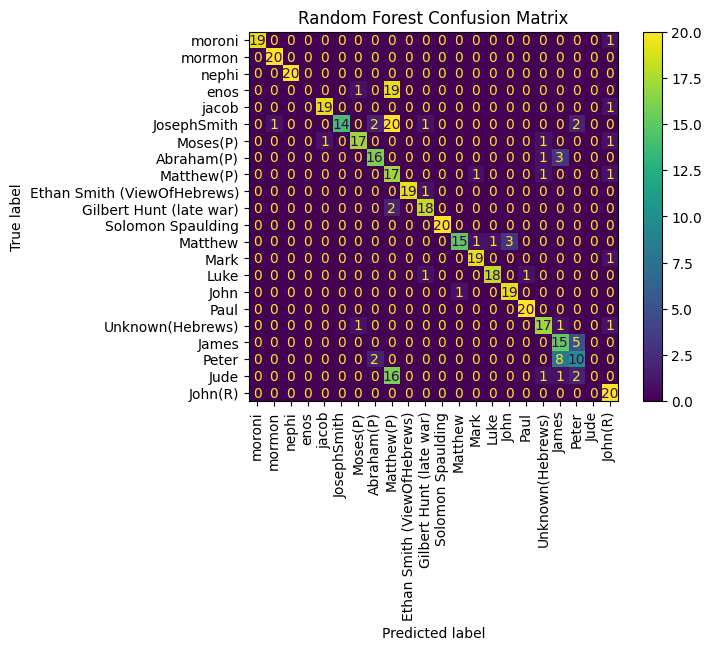

Epoch 1/1000


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1410 - loss: 2.4136 - val_accuracy: 0.3929 - val_loss: 2.3201
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4223 - loss: 2.1314 - val_accuracy: 0.5000 - val_loss: 1.9708
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5453 - loss: 1.6362 - val_accuracy: 0.6786 - val_loss: 1.5189
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6457 - loss: 1.1973 - val_accuracy: 0.6905 - val_loss: 1.1808
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6963 - loss: 0.9301 - val_accuracy: 0.6548 - val_loss: 1.0259
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7315 - loss: 0.7024 - val_accuracy: 0.7024 - val_loss: 0.8792
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7696 - loss: 0.5841 - val_accuracy: 0.6548 - val_loss: 0.8338
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7949 - loss: 0.5064 - val_accuracy: 0.6429 - val_loss: 0.89

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1542 - loss: 2.4197
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4914 - loss: 2.0837
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5632 - loss: 1.6822
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6833 - loss: 1.2623 
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6786 - loss: 1.0530
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7123 - loss: 0.8491
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7298 - loss: 0.7431
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7569 - loss: 0.6434
Epoch 9/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7833 - loss: 0.5659
Epoch 10/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7798 - loss: 0.5079
Epoch 11/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8285 - loss: 0.4497
Epoch 12/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8021 - loss: 0.4449
Epoch 13/32
9/9 ━━━━━━━

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


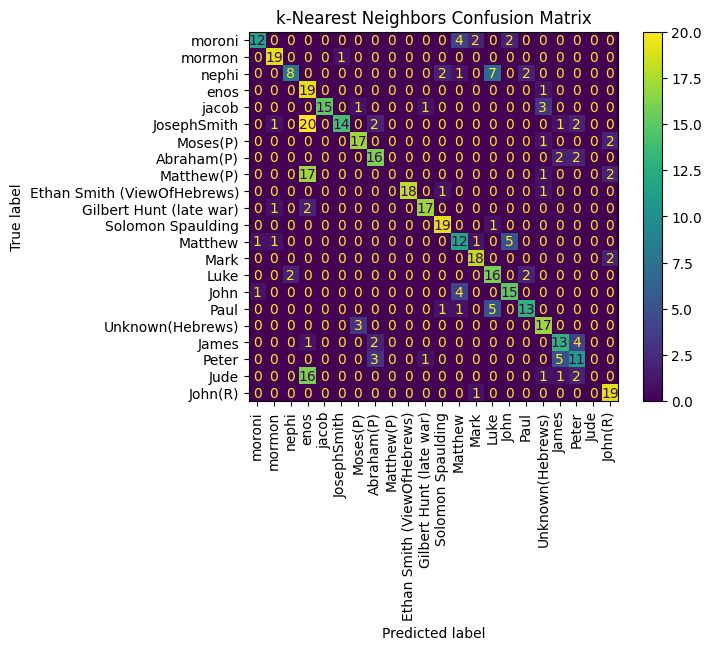

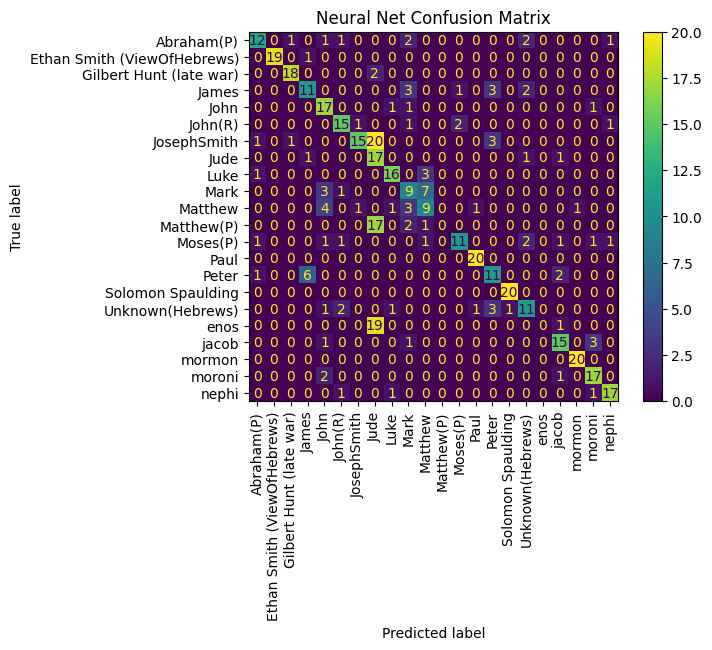

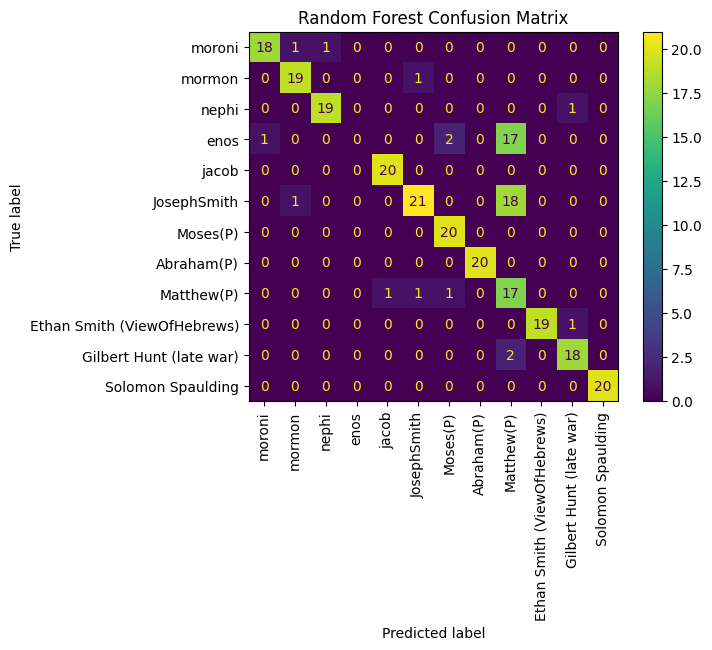

Epoch 1/1000


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0822 - loss: 2.6659 - val_accuracy: 0.2083 - val_loss: 2.5393
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3227 - loss: 2.4073 - val_accuracy: 0.4375 - val_loss: 2.2007
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4926 - loss: 1.9326 - val_accuracy: 0.5312 - val_loss: 1.7593
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6010 - loss: 1.4269 - val_accuracy: 0.6042 - val_loss: 1.3541
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6648 - loss: 1.1000 - val_accuracy: 0.6042 - val_loss: 1.1206
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7149 - loss: 0.8304 - val_accuracy: 0.6042 - val_loss: 0.9048
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7707 - loss: 0.6091 - val_accuracy: 0.5938 - val_loss: 1.0050
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8016 - loss: 0.5534 - val_accuracy: 0.6250 - val_loss: 0.91

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


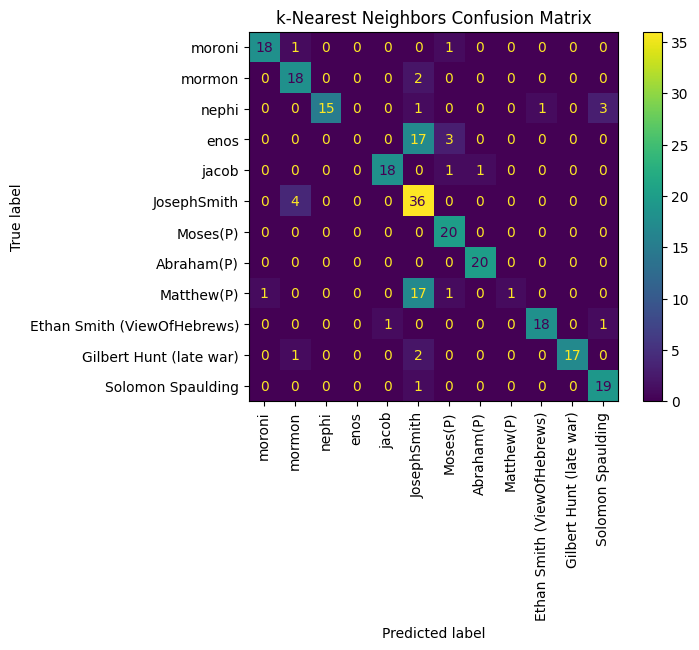

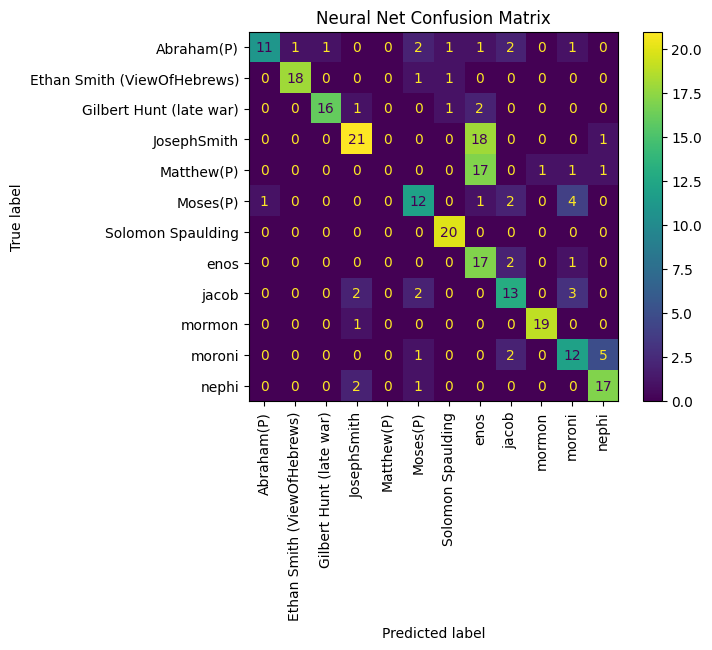

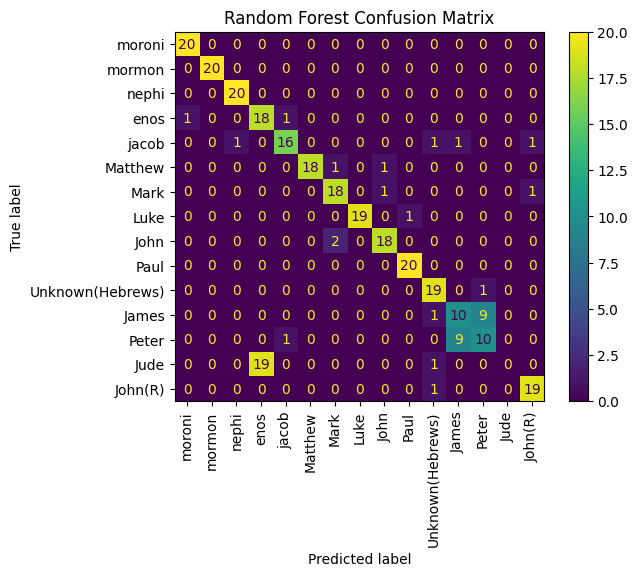

Epoch 1/1000


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.2326 - loss: 1.7214 - val_accuracy: 0.6410 - val_loss: 1.5860
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6004 - loss: 1.5196 - val_accuracy: 0.6410 - val_loss: 1.4066
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6994 - loss: 1.2723 - val_accuracy: 0.6923 - val_loss: 1.1540
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7610 - loss: 1.0107 - val_accuracy: 0.7949 - val_loss: 0.9695
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8327 - loss: 0.7706 - val_accuracy: 0.7436 - val_loss: 0.8392
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8781 - loss: 0.5615 - val_accuracy: 0.8205 - val_loss: 0.7495
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9129 - loss: 0.4537 - val_accuracy: 0.8462 - val_loss: 0.6144
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9276 - loss: 0.3573 - val_accuracy: 0.8205 - val_loss: 0.57

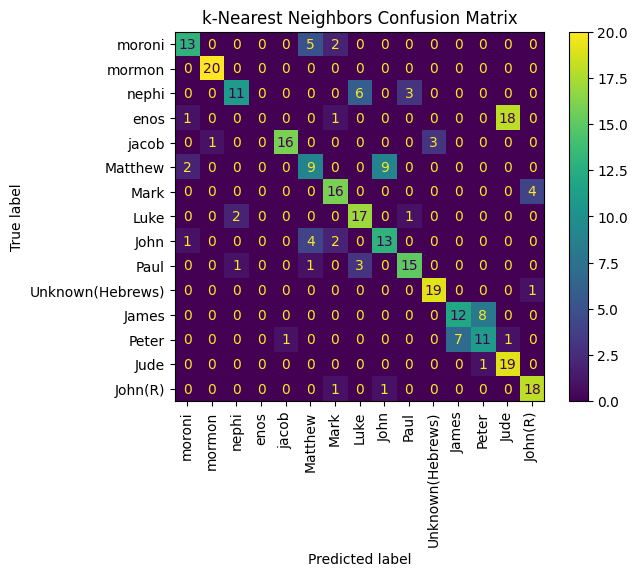

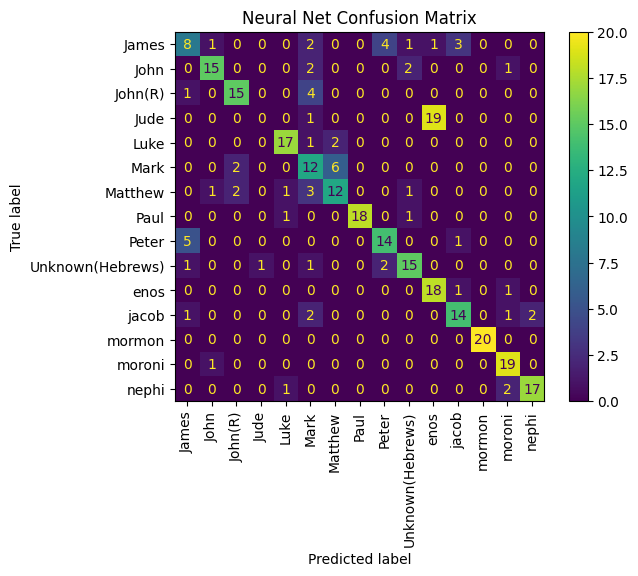

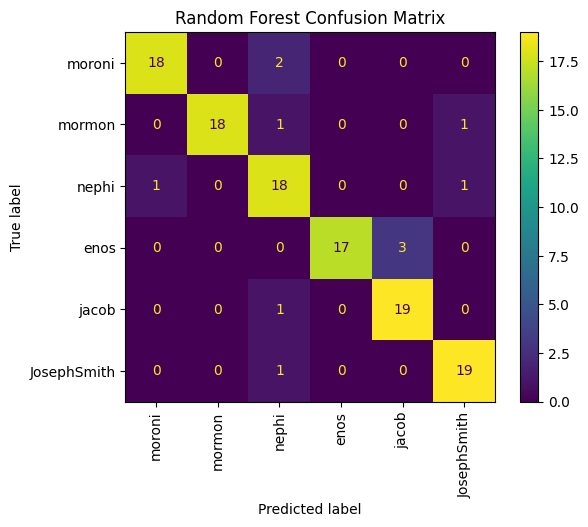

Epoch 1/1000


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1323 - loss: 2.1592 - val_accuracy: 0.2812 - val_loss: 2.0182
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3568 - loss: 1.9493 - val_accuracy: 0.4688 - val_loss: 1.8213
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5268 - loss: 1.6851 - val_accuracy: 0.5000 - val_loss: 1.5333
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6020 - loss: 1.3806 - val_accuracy: 0.5156 - val_loss: 1.3725
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6850 - loss: 1.0574 - val_accuracy: 0.5156 - val_loss: 1.2738
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7070 - loss: 0.8844 - val_accuracy: 0.5469 - val_loss: 1.1139
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7286 - loss: 0.7331 - val_accuracy: 0.5625 - val_loss: 0.9856
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7499 - loss: 0.6206 - val_accuracy: 0.5469 - val_loss: 0.96

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2086 - loss: 2.1361  
Epoch 2/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4794 - loss: 1.8741 
Epoch 3/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5710 - loss: 1.6079 
Epoch 4/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5861 - loss: 1.3156 
Epoch 5/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6582 - loss: 1.1249 
Epoch 6/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7028 - loss: 0.9106 
Epoch 7/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7050 - loss: 0.7760 
Epoch 8/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7214 - loss: 0.6658
Epoch 9/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7570 - loss: 0.5810 
Epoch 10/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7475 - loss: 0.5340 
Epoch 11/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7884 - loss: 0.5044 
Epoch 12/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7806 - loss: 0.4641 
Epoch 13/32


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


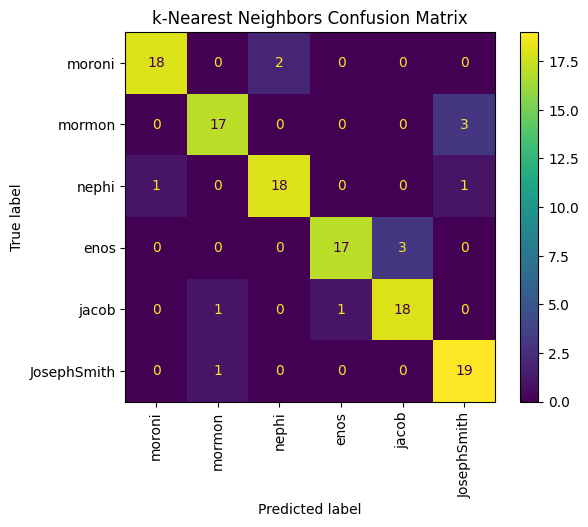

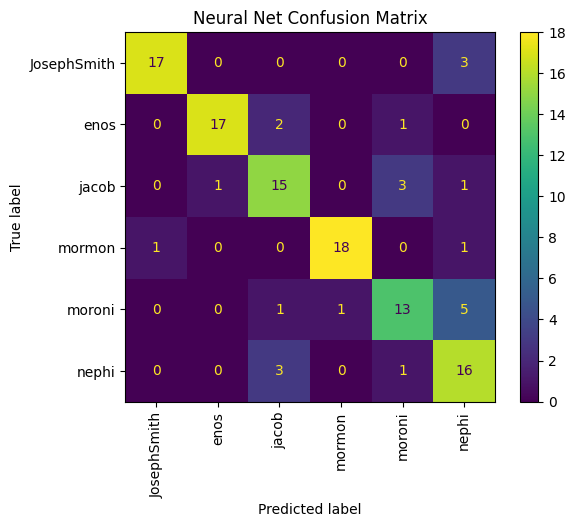

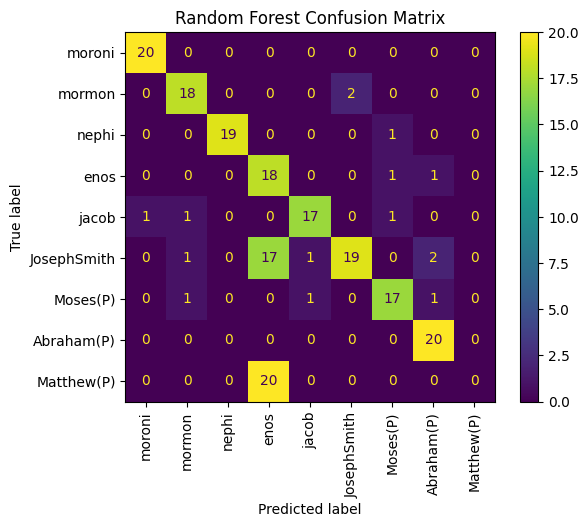

Epoch 1/1000


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.1346 - loss: 2.1192 - val_accuracy: 0.2414 - val_loss: 1.9196
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3639 - loss: 1.8777 - val_accuracy: 0.6034 - val_loss: 1.6759
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5395 - loss: 1.6640 - val_accuracy: 0.4655 - val_loss: 1.5452
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5279 - loss: 1.3971 - val_accuracy: 0.7069 - val_loss: 1.2417
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6593 - loss: 1.1479 - val_accuracy: 0.6724 - val_loss: 1.1180
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6711 - loss: 0.9685 - val_accuracy: 0.6897 - val_loss: 0.9757
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6636 - loss: 0.8708 - val_accuracy: 0.7069 - val_loss: 0.8426
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7001 - loss: 0.6991 - val_accuracy: 0.6034 - val_loss: 0.85

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


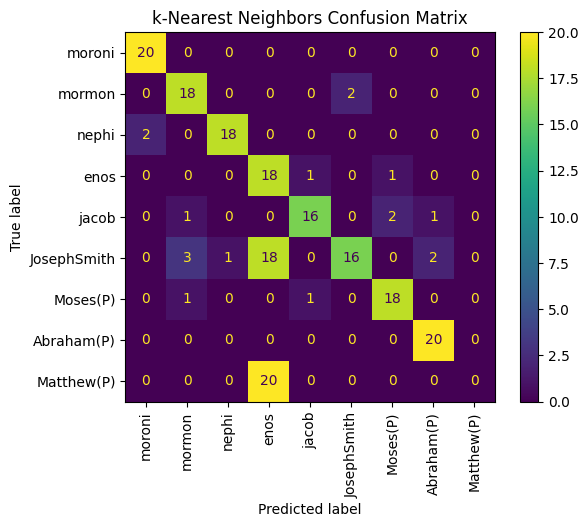

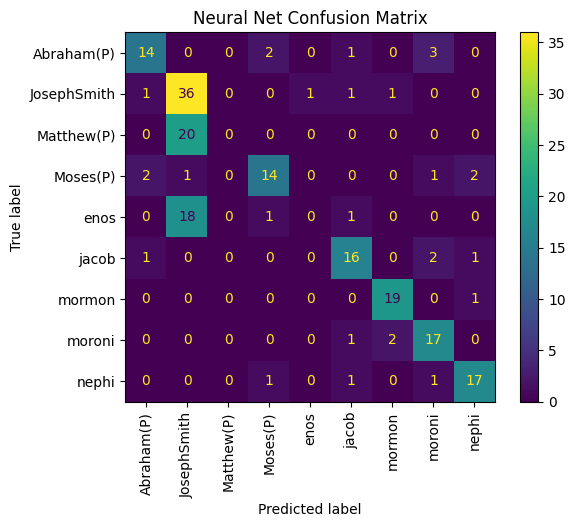

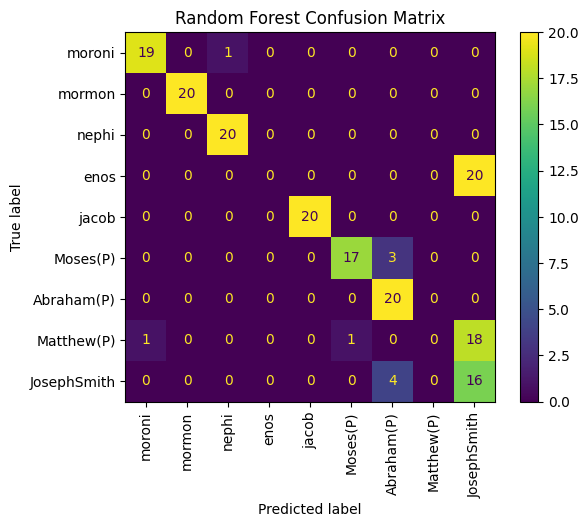

Epoch 1/1000


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2216 - loss: 2.0190 - val_accuracy: 0.5000 - val_loss: 1.7665
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5323 - loss: 1.7099 - val_accuracy: 0.6154 - val_loss: 1.3193
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7433 - loss: 1.2410 - val_accuracy: 0.7308 - val_loss: 0.9125
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7915 - loss: 0.8833 - val_accuracy: 0.6923 - val_loss: 0.8751
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7958 - loss: 0.7626 - val_accuracy: 0.8269 - val_loss: 0.5547
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8902 - loss: 0.5160 - val_accuracy: 0.8077 - val_loss: 0.5411
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8836 - loss: 0.4206 - val_accuracy: 0.8269 - val_loss: 0.4280
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9175 - loss: 0.3154 - val_accuracy: 0.8462 - val_loss: 0.39

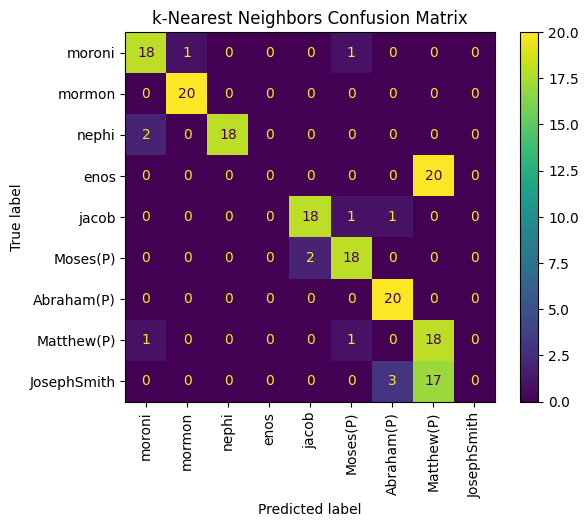

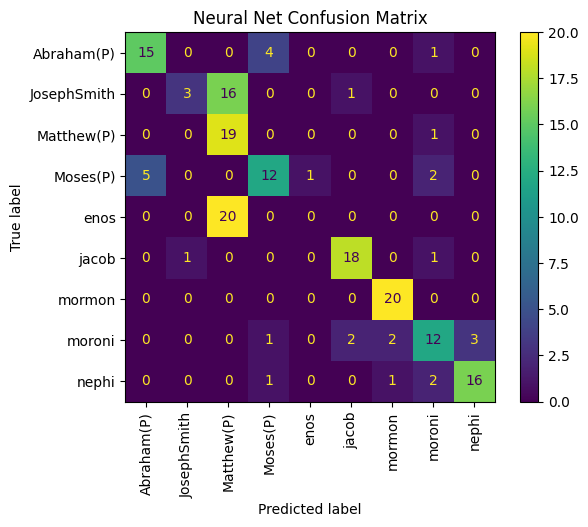

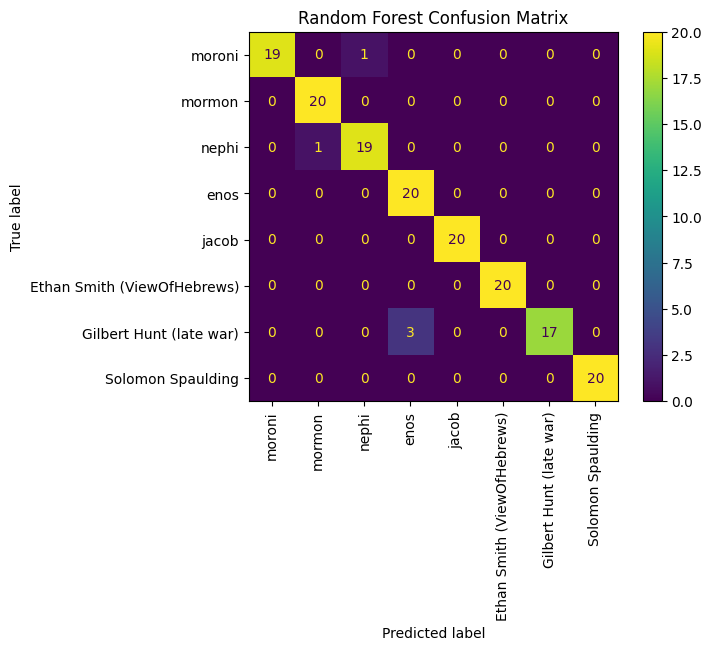

Epoch 1/1000


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.2868 - loss: 1.3423 - val_accuracy: 0.8846 - val_loss: 1.0144
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7408 - loss: 1.0081 - val_accuracy: 1.0000 - val_loss: 0.6462
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9111 - loss: 0.6248 - val_accuracy: 1.0000 - val_loss: 0.3439
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9216 - loss: 0.3523 - val_accuracy: 1.0000 - val_loss: 0.1734
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9579 - loss: 0.1854 - val_accuracy: 1.0000 - val_loss: 0.0997
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9698 - loss: 0.1235 - val_accuracy: 0.9615 - val_loss: 0.1024
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9788 - loss: 0.0969 - val_accuracy: 1.0000 - val_loss: 0.0546
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9929 - loss: 0.0384 - val_accuracy: 1.0000 - val_loss: 0.03

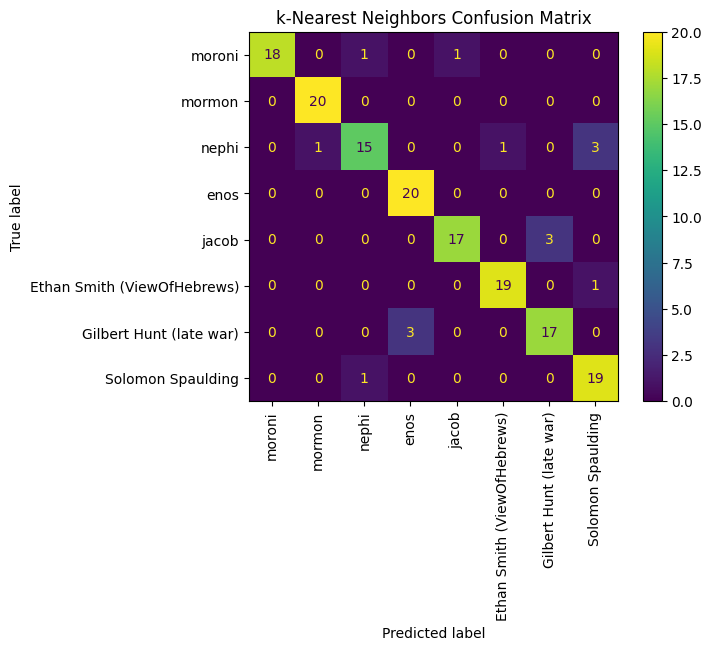

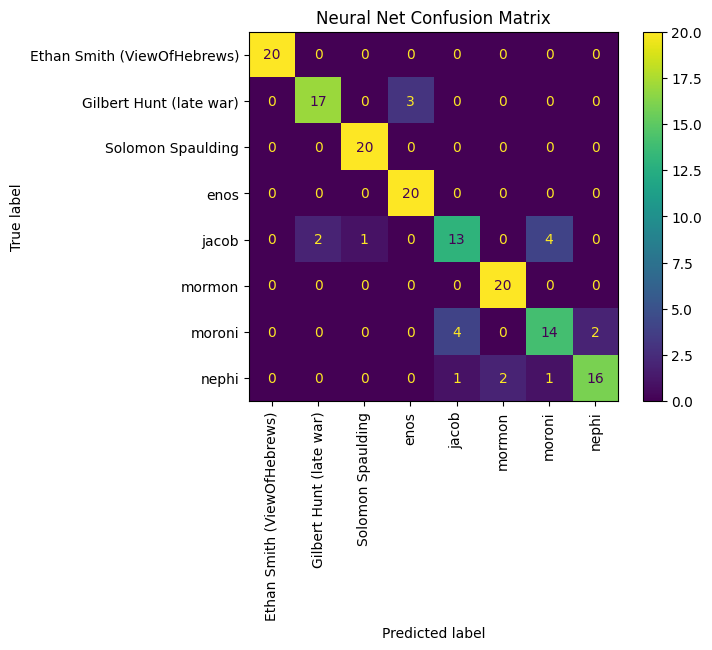

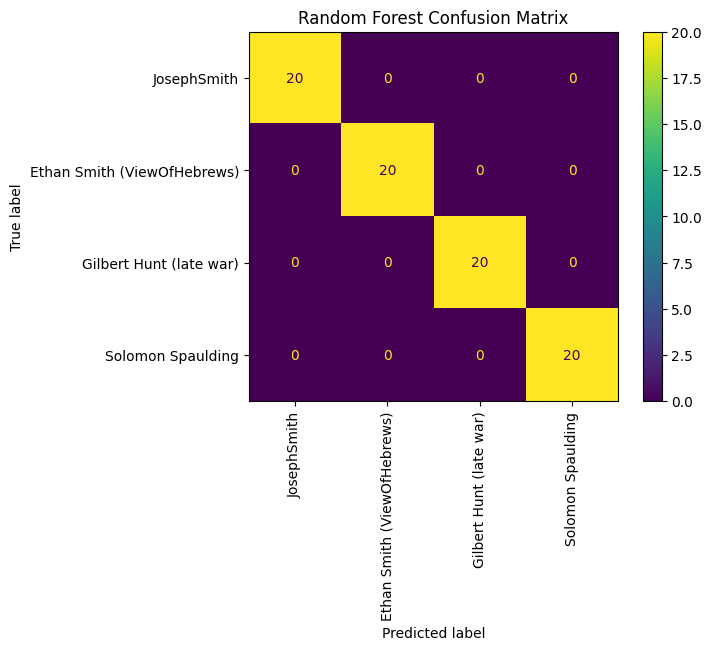

Epoch 1/1000


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.3114 - loss: 1.5724 - val_accuracy: 0.4375 - val_loss: 1.4181
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4642 - loss: 1.3797 - val_accuracy: 0.7812 - val_loss: 1.2911
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6843 - loss: 1.2150 - val_accuracy: 0.8438 - val_loss: 1.1358
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8001 - loss: 1.0102 - val_accuracy: 0.7812 - val_loss: 1.0034
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8672 - loss: 0.8263 - val_accuracy: 0.8125 - val_loss: 0.8814
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8758 - loss: 0.7170 - val_accuracy: 0.8438 - val_loss: 0.8370
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9089 - loss: 0.5505 - val_accuracy: 0.7812 - val_loss: 0.7734
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9410 - loss: 0.4541 - val_accuracy: 0.8125 - val_loss: 0.73

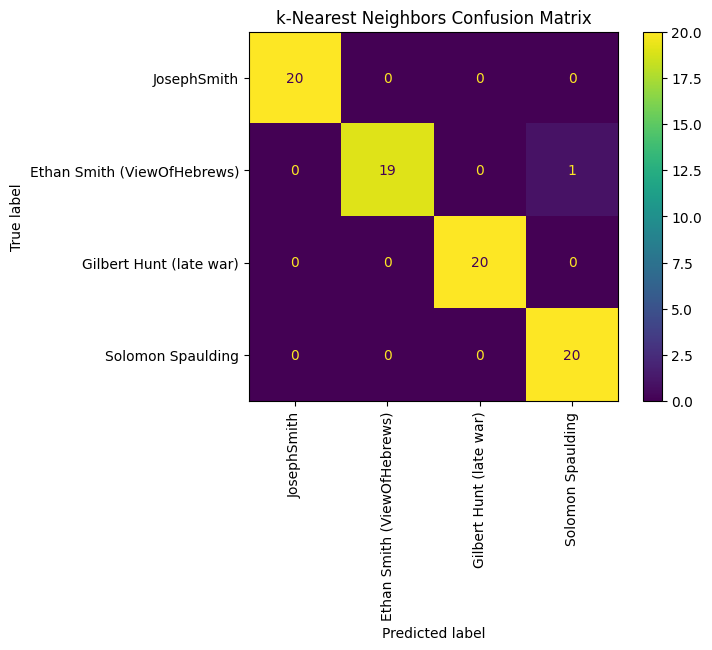

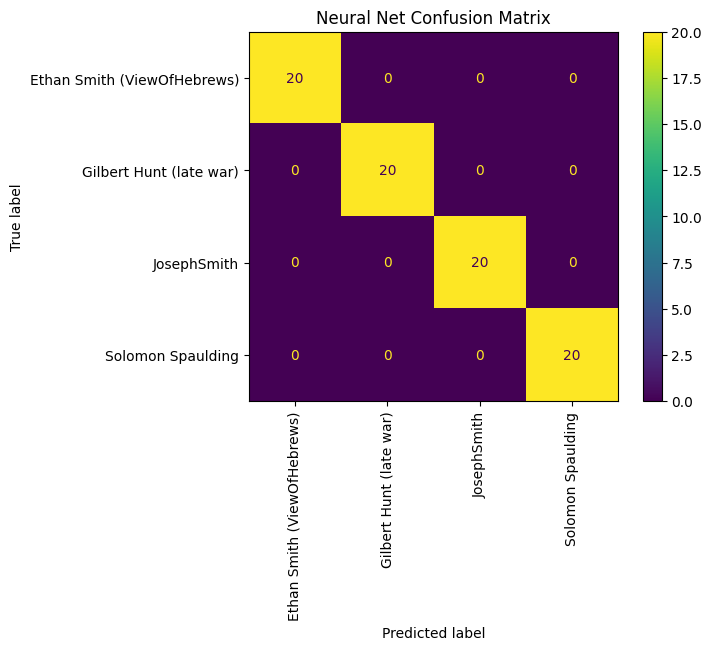

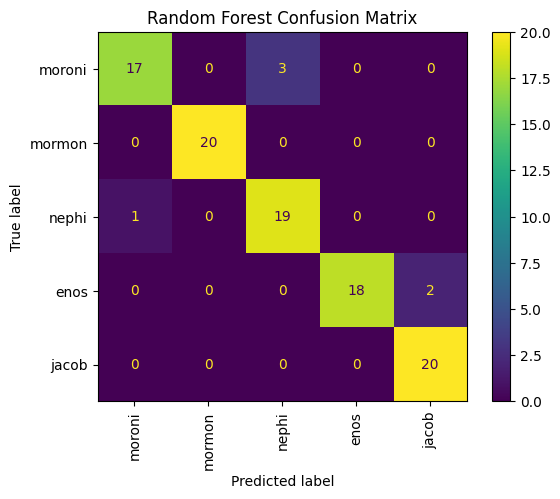

Epoch 1/1000


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1153 - loss: 2.2738 - val_accuracy: 0.2188 - val_loss: 2.1443
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3077 - loss: 2.0971 - val_accuracy: 0.6250 - val_loss: 1.8868
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5703 - loss: 1.8100 - val_accuracy: 0.6875 - val_loss: 1.5290
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6584 - loss: 1.4460 - val_accuracy: 0.7188 - val_loss: 1.2227
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7399 - loss: 1.0679 - val_accuracy: 0.7500 - val_loss: 0.9615
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7844 - loss: 0.8345 - val_accuracy: 0.7656 - val_loss: 0.8861
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8181 - loss: 0.6496 - val_accuracy: 0.8281 - val_loss: 0.7181
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8548 - loss: 0.4519 - val_accuracy: 0.8281 - val_loss: 0.73

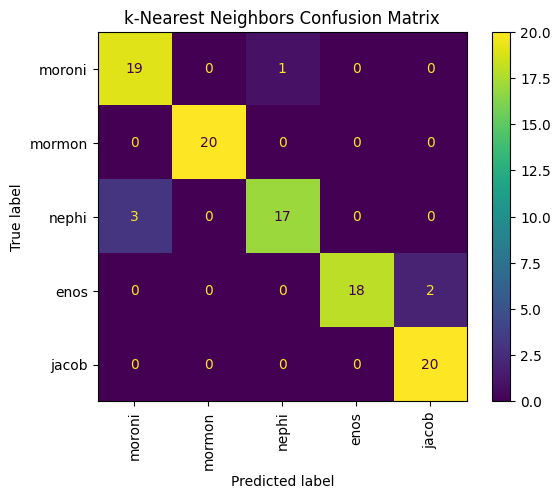

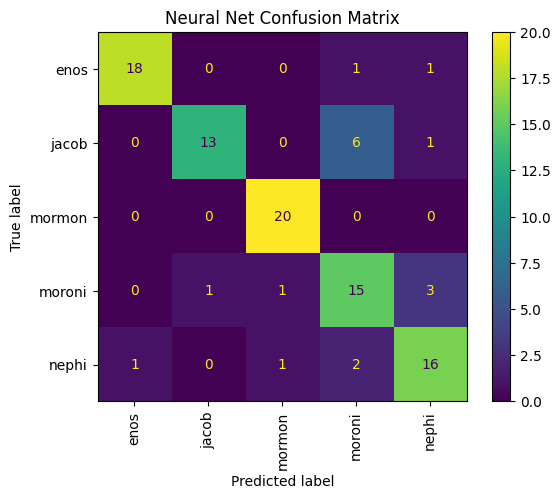

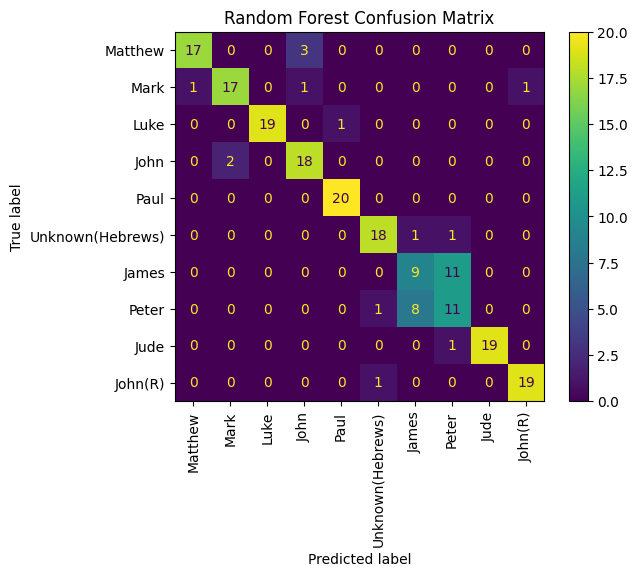

Metrics saved to metrics_report.xlsx


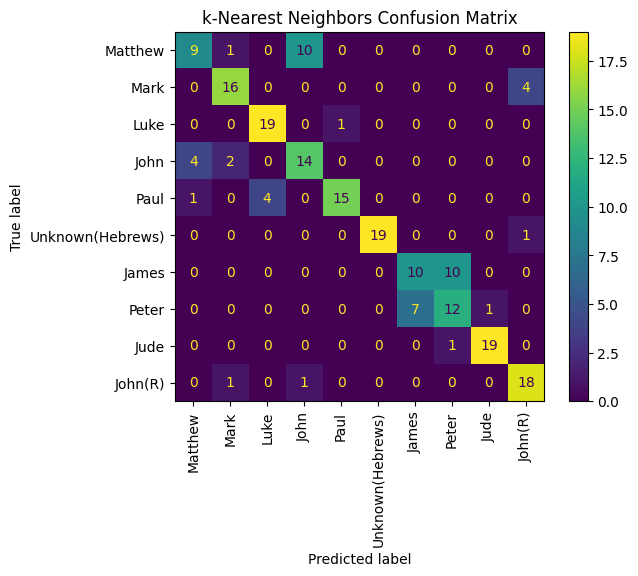

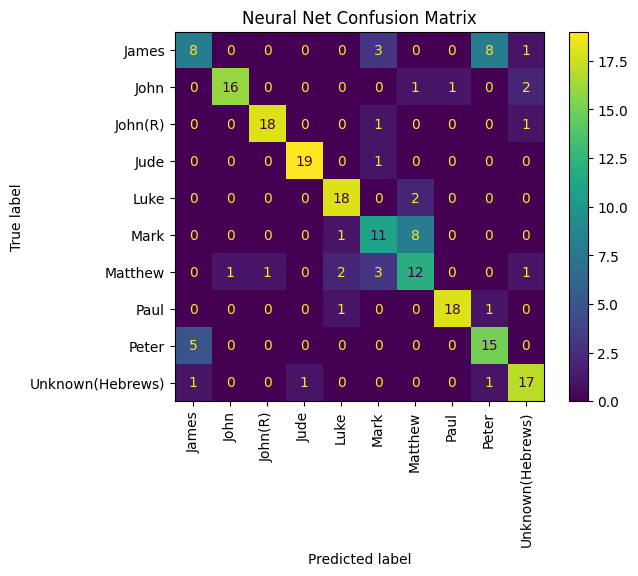

In [30]:
import shutil
excel_data = {}
for i in combos:
    folder_path = f"{i[0]}"
    if os.path.exists(f'Graphs\\{folder_path}'):
        shutil.rmtree(f"Graphs\\{folder_path}")
        os.makedirs(f'Graphs\\{folder_path}')
    else:
        os.makedirs(f'Graphs\\{folder_path}')
    
    df = pd.concat(i[1:], ignore_index=True)
    df = df.fillna(0)

    target = df["Author"]
    features = df.drop(columns=["Author"])
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
    X_train, y_train = shuffle(X_train, y_train, random_state=42)


    hyperparameters = {'bootstrap': False,
                'max_depth': 39,
                'min_samples_leaf': 2,
                'min_samples_split': 2,
                'n_estimators': 631}


    rf_model = RandomForestClassifier(**hyperparameters)

    rf_model.fit(X_train, y_train)

    rf_y_pred = rf_model.predict(X_test)

    rf_accuracy = accuracy_score(y_test, rf_y_pred)
    rf_precision = precision_score(y_test, rf_y_pred, average='weighted') 
    rf_recall = recall_score(y_test, rf_y_pred, average='weighted')  
    rf_f1 = f1_score(y_test, rf_y_pred, average='weighted')  
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    knn = KNeighborsClassifier(n_neighbors=10)

    knn.fit(X_train, y_train)


    k_predictions = knn.predict(X_test)

    k_accuracy = accuracy_score(y_test, k_predictions)
    k_precision = precision_score(y_test, k_predictions, average='weighted')  # Other options: 'micro', 'macro'
    k_recall = recall_score(y_test, k_predictions, average='weighted')  # Other options: 'micro', 'macro'
    k_f1 = f1_score(y_test, k_predictions, average='weighted')  # Other options: 'micro', 'macro'
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    def create_model(X_train, num_authors, structure):
        features_in_data = X_train.shape[1]
        model = Sequential()
        model.add(Dense(features_in_data, input_dim=features_in_data, activation='relu'))
        for i in structure:
            model.add(Dense(i, activation='relu'))
            model.add(Dropout(0.3))
            #model.add(BatchNormalization())
        model.add(Dense(num_authors, activation = 'softmax' ))
        #custom_learning_rate = 0.001
        custom_learning_rate = 0.01
        optimizer = Adam(learning_rate=custom_learning_rate)
        model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics = ['accuracy'])
        return model


    features = df.drop(columns=["Author"])
    minMaxScaler = MinMaxScaler()
    features_scaled = pd.DataFrame(minMaxScaler.fit_transform(features), columns=features.columns)
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)
    X_train, y_train = shuffle(X_train, y_train, random_state=42)

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    num_authors = len(label_encoder.classes_)

    optimizer = Adam(learning_rate=0.0009)

    structure =[
    1024,512
    ]

    model = create_model(X_train, num_authors, structure)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])


    early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)
    history = model.fit(X_train, y_train_encoded, epochs=1000, validation_split=0.08, batch_size=128, callbacks=[early_stop], shuffle=True)
    hist = pd.DataFrame(history.history)

    class_names = label_encoder.classes_
    label_to_name = dict(zip(range(len(class_names)), class_names))
    n_y_pred = model.predict(X_test)
    all_labels = pd.concat([y_train, y_test], axis=0)
    label_encoder.fit(all_labels)
    y_train_encoded = label_encoder.transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    n_predicted_labels = label_encoder.inverse_transform(n_y_pred.argmax(axis=1))

    n_accuracy = accuracy_score(y_test, n_predicted_labels)

    n_precision, n_recall, n_f1_score_nn, N_support = precision_recall_fscore_support(y_test, n_predicted_labels, average='weighted')
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    def create_ensemble_model(input_shape, num_authors, structure):
        model = Sequential()
        model.add(InputLayer(shape=(input_shape,)))
        for units in structure:
            model.add(Dense(units, activation='relu'))
            model.add(Dropout(0.3))
        model.add(Dense(num_authors, activation='softmax'))
        optimizer = Adam(learning_rate=0.0009)
        model.compile(loss='crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

    scikit_nn = KerasClassifier(model=create_ensemble_model, input_shape=X_train.shape[1], num_authors=num_authors, structure=[1024, 512], epochs=32, batch_size=128)


    ensemble_model = VotingClassifier(estimators=[
        ('nn', scikit_nn),
        ('knn', knn),
        ('rf', rf_model)
    ], voting='hard')

    # Train the ensemble model
    ensemble_model.fit(X_train, y_train)

    # 5. Predict using the ensemble model
    e_y_pred = ensemble_model.predict(X_test)

    # 6. Evaluate the model
    e_accuracy = accuracy_score(y_test, e_y_pred)
    e_precision = precision_score(y_test, e_y_pred, average='weighted')  # Other options: 'micro', 'macro'
    e_recall = recall_score(y_test, e_y_pred, average='weighted')  # Other options: 'micro', 'macro'
    e_f1 = f1_score(y_test, e_y_pred, average='weighted')  # Other options: 'micro', 'macro'
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    metrics = {
    "Random Forest": [rf_accuracy, rf_precision, rf_recall, rf_f1],
    "KNN": [k_accuracy, k_precision, k_recall, k_f1],
    "Neural Net": [n_accuracy, n_precision, n_recall, n_f1_score_nn],
    "Ensemble Model": [e_accuracy, e_precision, e_recall, e_f1]
    } 
    excel_data[folder_path] = metrics
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    ######################################################################################################################################################################

    cm = confusion_matrix(y_test, rf_y_pred, labels=target.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target.unique())
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title("Random Forest Confusion Matrix")

    plt.savefig(f"Graphs\\{folder_path}\\rf.png")

    ######################################################################################################################################################################
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    plt.show()
    cm = confusion_matrix(y_test, k_predictions, labels=target.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target.unique())
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title("k-Nearest Neighbors Confusion Matrix")


    plt.savefig(f"Graphs\\{folder_path}\\knn.png")


    ######################################################################################################################################################################
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    all_labels = pd.concat([y_train, y_test], axis=0)
    label_encoder.fit(all_labels)


    y_train_encoded = label_encoder.transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)


    predicted_labels = label_encoder.inverse_transform(n_y_pred.argmax(axis=1))



    cm = confusion_matrix(y_test, predicted_labels, labels=label_encoder.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title("Neural Net Confusion Matrix")

    plt.savefig(f"Graphs\\{folder_path}\\NN.png")

df_data = []

# Create a list of the column titles (combos)
columns = list(excel_data.keys())

# Populate the rows for each model
for model in metrics.keys():
    # Gather the metrics for the current model across all combos
    row = []
    for folder_path in columns:
        # Get the metrics for the model in the current folder_path combo
        values = excel_data[folder_path].get(model)
        
        # Format the metrics as required, separated by new lines
        metric_string = '\n'.join([f"{metric_name}: {value:.4f}" 
                                  for metric_name, value in zip(['Accuracy', 'Precision', 'Recall', 'F1-Score'], values)])
        
        row.append(metric_string)
    
    # Append the row data for the model
    df_data.append(row)

# Create a DataFrame from the data
df = pd.DataFrame(df_data, index=metrics.keys(), columns=columns)

# Export to Excel

excel_filename = f"metrics_report.xlsx"  # Save file in the current directory or specify path
if os.path.exists(f'{excel_filename}'):
    os.remove(excel_filename)

df.to_excel(excel_filename, index=True)

print(f"Metrics saved to {excel_filename}")


## Model runs

In [31]:
target = df["Author"]
features = df.drop(columns=["Author"])
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
X_train, y_train = shuffle(X_train, y_train, random_state=42)


hyperparameters = {'bootstrap': False,
             'max_depth': 39,
             'min_samples_leaf': 2,
             'min_samples_split': 2,
             'n_estimators': 631}


rf_model = RandomForestClassifier(**hyperparameters)

rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred, average='weighted') 
rf_recall = recall_score(y_test, rf_y_pred, average='weighted')  
rf_f1 = f1_score(y_test, rf_y_pred, average='weighted')  

KeyError: 'Author'

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, y_train)


k_predictions = knn.predict(X_test)

k_accuracy = accuracy_score(y_test, k_predictions)
k_precision = precision_score(y_test, k_predictions, average='weighted')  # Other options: 'micro', 'macro'
k_recall = recall_score(y_test, k_predictions, average='weighted')  # Other options: 'micro', 'macro'
k_f1 = f1_score(y_test, k_predictions, average='weighted')  # Other options: 'micro', 'macro'

In [ ]:
def create_model(X_train, num_authors, structure):
  features_in_data = X_train.shape[1]
  model = Sequential()
  model.add(Dense(features_in_data, input_dim=features_in_data, activation='relu'))
  for i in structure:
    model.add(Dense(i, activation='relu'))
    model.add(Dropout(0.3))
    #model.add(BatchNormalization())
  model.add(Dense(num_authors, activation = 'softmax' ))
  #custom_learning_rate = 0.001
  custom_learning_rate = 0.01
  optimizer = Adam(learning_rate=custom_learning_rate)
  model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics = ['accuracy'])
  return model


features = df.drop(columns=["Author"])
minMaxScaler = MinMaxScaler()
features_scaled = pd.DataFrame(minMaxScaler.fit_transform(features), columns=features.columns)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
num_authors = len(label_encoder.classes_)

optimizer = Adam(learning_rate=0.0009)

structure =[
1024,512
]

model = create_model(X_train, num_authors, structure)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])


early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)
history = model.fit(X_train, y_train_encoded, epochs=1000, validation_split=0.08, batch_size=128, callbacks=[early_stop], shuffle=True)
hist = pd.DataFrame(history.history)

class_names = label_encoder.classes_
label_to_name = dict(zip(range(len(class_names)), class_names))
n_y_pred = model.predict(X_test)
all_labels = pd.concat([y_train, y_test], axis=0)
label_encoder.fit(all_labels)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
n_predicted_labels = label_encoder.inverse_transform(n_y_pred.argmax(axis=1))

n_accuracy = accuracy_score(y_test, n_predicted_labels)

n_precision, n_recall, n_f1_score_nn, N_support = precision_recall_fscore_support(y_test, n_predicted_labels, average='weighted')


Epoch 1/1000


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3012 - loss: 1.3459 - val_accuracy: 0.6154 - val_loss: 0.9982
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5684 - loss: 1.0269 - val_accuracy: 0.8846 - val_loss: 0.6442
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9094 - loss: 0.6758 - val_accuracy: 0.8846 - val_loss: 0.4684
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9104 - loss: 0.3912 - val_accuracy: 0.9231 - val_loss: 0.2253
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9535 - loss: 0.2390 - val_accuracy: 0.9615 - val_loss: 0.1745
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9515 - loss: 0.1536 - val_accuracy: 1.0000 - val_loss: 0.0898
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9525 - loss: 0.1284 - val_accuracy: 0.9615 - val_loss: 0.0826
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9800 - loss: 0.0789 - val_accuracy: 1.0000 - val_loss: 0.04

In [ ]:
def create_ensemble_model(input_shape, num_authors, structure):
    model = Sequential()
    model.add(InputLayer(shape=(input_shape,)))
    for units in structure:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.3))
    model.add(Dense(num_authors, activation='softmax'))
    optimizer = Adam(learning_rate=0.0009)
    model.compile(loss='crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

scikit_nn = KerasClassifier(model=create_ensemble_model, input_shape=X_train.shape[1], num_authors=num_authors, structure=[1024, 512], epochs=32, batch_size=128)


ensemble_model = VotingClassifier(estimators=[
    ('nn', scikit_nn),
    ('knn', knn),
    ('rf', rf_model)
], voting='hard')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# 5. Predict using the ensemble model
e_y_pred = ensemble_model.predict(X_test)

# 6. Evaluate the model
e_accuracy = accuracy_score(y_test, e_y_pred)
e_precision = precision_score(y_test, e_y_pred, average='weighted')  # Other options: 'micro', 'macro'
e_recall = recall_score(y_test, e_y_pred, average='weighted')  # Other options: 'micro', 'macro'
e_f1 = f1_score(y_test, e_y_pred, average='weighted')  # Other options: 'micro', 'macro'


Epoch 1/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3488 - loss: 1.3267  
Epoch 2/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7488 - loss: 0.9444 
Epoch 3/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9246 - loss: 0.5948 
Epoch 4/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9131 - loss: 0.4034 
Epoch 5/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9502 - loss: 0.2627 
Epoch 6/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9711 - loss: 0.1634 
Epoch 7/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9814 - loss: 0.1148 
Epoch 8/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9859 - loss: 0.0960 
Epoch 9/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9984 - loss: 0.0595 
Epoch 10/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0452 
Epoch 11/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9955 - loss: 0.0401 
Epoch 12/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0291 


In [ ]:
# import os
import pandas as pd

# filename = "metrics_report.txt"

# with open(filename, "w") as file:
#     file.write(f"{folder_path}")

#     file.write("Random Forest\n")
#     file.write(f"Accuracy: {rf_accuracy}\n")
#     file.write(f"Precision: {rf_precision}\n")
#     file.write(f"Recall: {rf_recall}\n")
#     file.write(f"F1 Score: {rf_f1}\n\n")
    
#     file.write("KNN\n")
#     file.write(f"Accuracy: {k_accuracy}\n")
#     file.write(f"Precision: {k_precision}\n")
#     file.write(f"Recall: {k_recall}\n")
#     file.write(f"F1 Score: {k_f1}\n\n")
    
#     file.write("Neural Net\n")
#     file.write(f"Accuracy: {n_accuracy}\n")
#     file.write(f"Precision: {n_precision}\n")
#     file.write(f"Recall: {n_recall}\n")
#     file.write(f"F1 Score: {f1_score_nn}\n\n")
    
#     file.write("Ensemble Model\n")
#     file.write(f"Accuracy: {e_accuracy}\n")
#     file.write(f"Precision: {e_precision}\n")
#     file.write(f"Recall: {e_recall}\n")
#     file.write(f"F1-Score: {e_f1}\n")



# Metrics for each model
metrics = {
    "Random Forest": [rf_accuracy, rf_precision, rf_recall, rf_f1],
    "KNN": [k_accuracy, k_precision, k_recall, k_f1],
    "Neural Net": [n_accuracy, n_precision, n_recall, f1_score_nn],
    "Ensemble Model": [e_accuracy, e_precision, e_recall, e_f1]
}

# Create a DataFrame where each row contains metrics for a specific model
data = {}
for model, values in metrics.items():
    # Join metrics into a single string separated by newlines
    data[model] = '\n'.join(f"{metric:.4f}" for metric in values)

# Convert to DataFrame (rows = model names, columns = folder_path)
df = pd.DataFrame.from_dict(data, orient='index', columns=[folder_path])

# Export to Excel
excel_filename = f"{folder_path}metrics_report.xlsx"
df.to_excel(excel_filename, index=True)
print(f"Metrics saved to {excel_filename}")

ModuleNotFoundError: No module named 'openpyxl'

NameError: name 'folder_path' is not defined

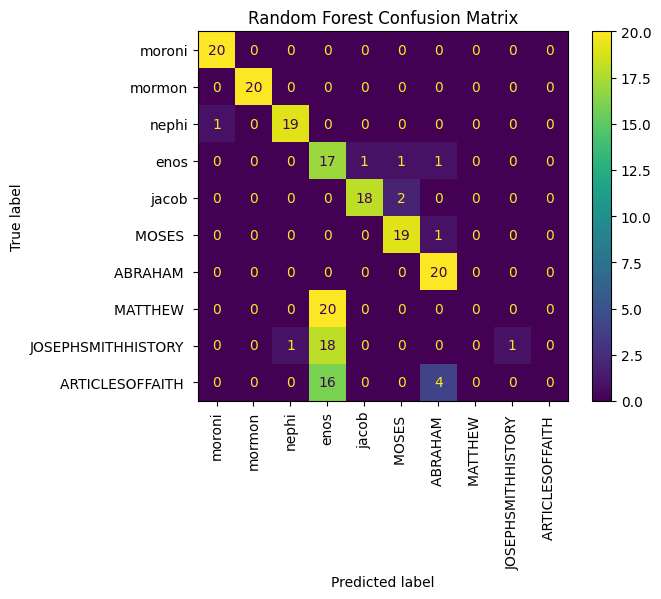

In [ ]:
cm = confusion_matrix(y_test, rf_y_pred, labels=target.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target.unique())
disp.plot(cmap="viridis", xticks_rotation='vertical')
plt.title("Random Forest Confusion Matrix")

plt.savefig(f"{folder_path}\rf.png")


plt.show()
cm = confusion_matrix(y_test, k_predictions, labels=target.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target.unique())
disp.plot(cmap="viridis", xticks_rotation='vertical')
plt.title("k-Nearest Neighbors Confusion Matrix")


plt.savefig(f"{folder_path}\knn.png")

plt.show()

all_labels = pd.concat([y_train, y_test], axis=0)
label_encoder.fit(all_labels)


y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


predicted_labels = label_encoder.inverse_transform(n_y_pred.argmax(axis=1))



cm = confusion_matrix(y_test, predicted_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="viridis", xticks_rotation='vertical')
plt.title("Neural Net Confusion Matrix")

plt.savefig(f"{folder_path}\NN.png")


plt.show()

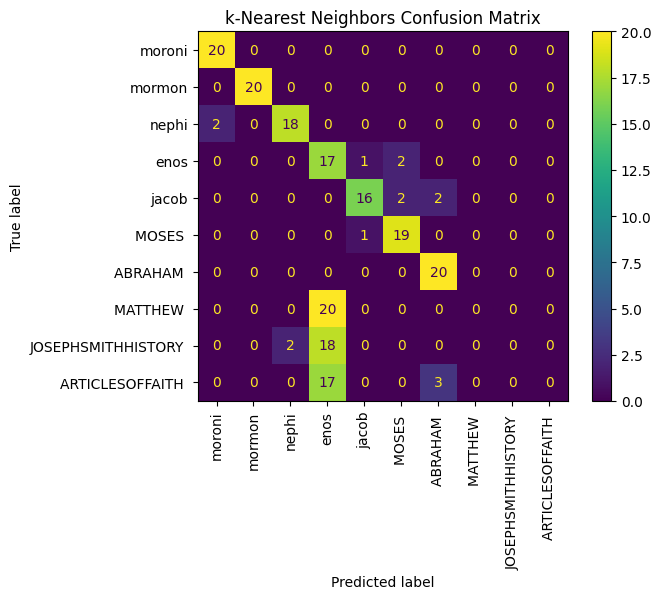

In [ ]:
cm = confusion_matrix(y_test, k_predictions, labels=target.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target.unique())
disp.plot(cmap="viridis", xticks_rotation='vertical')
plt.title("k-Nearest Neighbors Confusion Matrix")


plt.savefig(f"{folder_path}\knn.png")

plt.show()

all_labels = pd.concat([y_train, y_test], axis=0)
label_encoder.fit(all_labels)


y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


predicted_labels = label_encoder.inverse_transform(n_y_pred.argmax(axis=1))



cm = confusion_matrix(y_test, predicted_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="viridis", xticks_rotation='vertical')
plt.title("Neural Net Confusion Matrix")

plt.savefig(f"{folder_path}\NN.png")


plt.show()

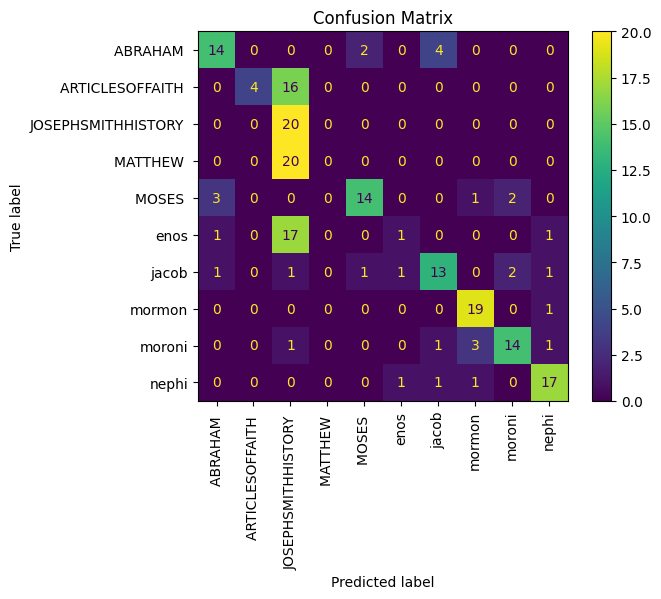

In [ ]:

all_labels = pd.concat([y_train, y_test], axis=0)
label_encoder.fit(all_labels)


y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


predicted_labels = label_encoder.inverse_transform(n_y_pred.argmax(axis=1))



cm = confusion_matrix(y_test, predicted_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="viridis", xticks_rotation='vertical')
plt.title("Neural Net Confusion Matrix")

plt.savefig(f"{folder_path}\NN.png")


plt.show()